In [78]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, linalg
from enum import Enum
from typing import Mapping

In [90]:
class PopulationSpec:
    
    def __init__(self, name, population, s, e, i, r, i_rate, r_rate):
        """Specs out a population's SEIR properties.
        
        Starting S, E, I, R, and population are provided, as well as
        the population's rate from exposed to infected, and infected to recovered.
        """
        self._name = name
        self._s = s
        self._e = e
        self._i = i
        self._r = r
        self._population = s + e + i + r
        self._i_rate = i_rate
        self._r_rate = r_rate
        
    def y0(self):
        return [self._s, self._e, self._i, self._r]
    
    def params(self):
        return [self._name + ': ' + x for x in ['s', 'e', 'i', 'r']]
        
    def population(self):
        return self._population
    
    def transition_matrix(self):
        return np.array([[0., 0., 0., 0.],
                         [0., -self._i_rate, 0., 0.],
                         [0., self._i_rate, -self._r_rate, 0.],
                         [0., 0., self._r_rate, 0.0],
                        ])
    
        
class InteractionSpec:
    
    def __init__(self, from_pop, to_pop, x_rate):
        """Rate of transmission between two populations.
        
        Populations can be the same population for internal transmission rates.
        """
        self._from_pop = from_pop
        self._to_pop = to_pop
        self._x_rate = x_rate
        
        

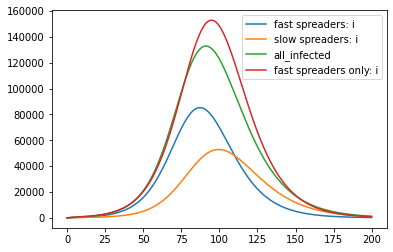

In [167]:
# Create specs
I_RATE = 1 / 5.1
R_RATE = 1 / 10.
E_RATE_FAST = 1 / 4. # R = 2.5
E_RATE_SLOW = 1 / 10. # R = 1
E_RATE_CROSS = 1 / 20. # R = 0.5
DAYS = 200


def simulate(pop_specs, xact_specs):
    y0 = np.zeros(0)
    A = np.zeros((0, 0))

    y0 = np.concatenate([pop_spec.y0() for pop_spec in pop_specs])
    A = linalg.block_diag(*[pop_spec.transition_matrix() for pop_spec in pop_specs])
    total_pop = sum([pop_spec.population() for pop_spec in pop_specs])

    pop_specs_indexed = dict([(y, x) for x, y in enumerate(pop_specs)])    

    t_init = 0.

    def ode_fn(t, y):
        A_complete = np.copy(A)
        for xact_spec in xact_specs:
            from_index = pop_specs_indexed[xact_spec._from_pop] * 4 + 2
            to_index = pop_specs_indexed[xact_spec._to_pop] * 4
            A_complete[to_index, to_index] -= y[from_index] * xact_spec._x_rate / xact_spec._to_pop.population()
            A_complete[to_index + 1, to_index] += y[from_index] * xact_spec._x_rate / xact_spec._to_pop.population()
        return A_complete.dot(y)

    results = integrate.RK45(ode_fn, t_init, y0, DAYS)

    t_seq = np.arange(0.1, DAYS, 0.1)
    y_all = []
    results.step()
    dense_output = results.dense_output()
    for t in t_seq:
        while t > dense_output.t_max:
            results.step()
            dense_output = results.dense_output()
        y_all.append(dense_output(t))


    labels = [pop.params() for pop in pop_specs]
    labels = [item for sublist in labels for item in sublist]
    return t_seq, labels, np.array(y_all)


pop_spec1 = PopulationSpec('fast spreaders', 500000, 500000 - 500, 500, 0, 0, I_RATE, R_RATE)
pop_spec2 = PopulationSpec('slow spreaders', 500000, 500000 - 500, 500, 0, 0, I_RATE, R_RATE)
pop_specs = [pop_spec1, pop_spec2]

xact_specs = []
xact_specs.append(InteractionSpec(pop_spec1, pop_spec1, E_RATE_FAST))
xact_specs.append(InteractionSpec(pop_spec1, pop_spec2, E_RATE_CROSS))
xact_specs.append(InteractionSpec(pop_spec2, pop_spec2, E_RATE_SLOW))
xact_specs.append(InteractionSpec(pop_spec2, pop_spec1, E_RATE_CROSS))

t_seq, labels, y_all = simulate(pop_specs, xact_specs)

for i in range(2, 4 * len(pop_specs), 4):
    plt.plot(t_seq, y_all[:,i], label=labels[i])
plt.plot(t_seq, np.sum(y_all[:,2::4], axis=-1), label='all_infected')


# Fast only prediction
pop_spec3 = PopulationSpec('fast spreaders only', 1000000, 1000000 - 1000, 1000, 0, 0, I_RATE, R_RATE)
xact_specs = []
xact_specs.append(InteractionSpec(pop_spec3, pop_spec3, E_RATE_FAST))
t_seq, labels, y_all = simulate([pop_spec3], xact_specs)
plt.plot(t_seq, y_all[:,2], label=labels[2])
#plt.yscale('log')
plt.legend()



In [7]:
y1

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.60199722, -0.40508831])>